In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
# Loading your IBM Q account(s)
#provider = IBMQ.load_account()
#need to everything in one circuit for it to plot

In [2]:
matplotlib.rc('text', usetex = True)
matplotlib.rc('font', **{'family' : "sans-serif"})
params= {'text.latex.preamble' : [r'\usepackage{amsmath}']}
figsize=(10,8)
width=0.75
color='black'

# Step 1: Initialisation 


In [3]:
#data and templates are all in binary form and we compare bit by bit
#define the registers. Completely arbitrary.
#n is the number of qubits(data and templates); nanc is the number of ancilla qubit; 
#p is the number of precision; nt is the number of qubits we are not comparing, starting from the 0th
n=5
nanc=1
a=n+nanc
#p=5
nt=1

In [4]:
p=int(np.round(np.log2(2*np.pi)+0.5*(n-nt)))
print(p)

5


### 1.1 creating registers

In [5]:
#to store the right templates
data = QuantumRegister(n,'data')
#the registers used to check, the last qubit is the ancilla
templates=QuantumRegister(a,'templates')
#the classical register to store the results, of the counting process and the final search process seperately
result_counting=ClassicalRegister(p,'result')
result_answer=ClassicalRegister(n,'answer')
#the counting register
counting=QuantumRegister(p,'counting')
#make the counting register in superposition
search_Circuit=QuantumCircuit(data,templates,counting,result_counting)

### 1.2 Initialising registers

This is to set the data we are matching agaisnt.

In the case of have multiple matching templates, we shall not use 'search_Circuit.h(data[0])'. This will create two data that we are matching agaist, rather than two natching templates. In this case, both data would run as superpostions and so will the matching result. In essense, it is still one template searching so no untilitisation of quantum counting.

The Z-gate on the counting qubit is to conpensate the general $\phi$ phase introduced by the Diffusion operator function.



In [6]:
#data is 0110 
search_Circuit.x(data[1])
search_Circuit.x(data[2])

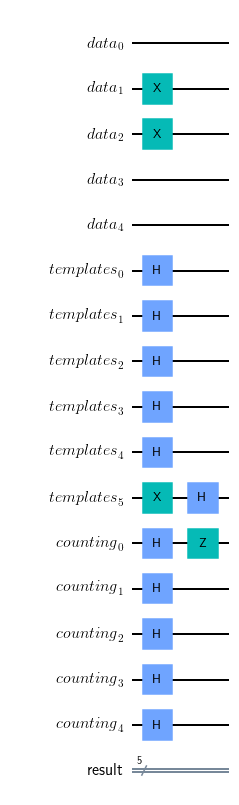

In [7]:
#search qubits are initialised to 0 while the ancilla is initialised to 1
search_Circuit.x(templates[n])
#Hadmard gate is applied to all qubits
search_Circuit.h(templates[0:a]) 
#counting qubits are initilised to + as well
search_Circuit.h(counting) 
search_Circuit.z(counting[0]) 
#search_Circuit.x(counting[0]) 
#search_Circuit.x(counting[1]) 
search_Circuit.draw(output="mpl")

# Step 2: Creating Grover's gate 

In [8]:
1126259463#unfortunately qiskit does not have ccccx gate so we have to define
#This is good because we dont have to put in number of qubits by hand
from qiskit.circuit.library.standard_gates import XGate,ZGate
def controlx(n):
    cx_gate = XGate().control(n)
    return cx_gate
def controlz(n):
    cz_gate = ZGate().control(n)
    return cz_gate

### 2.1 Creating the Oracle function

In [9]:
#templace matching oracle: one template
#data bit match with template bit
#cx: is a classical AND gate, the result is on the second qubit.  ,templates,data
def template_matching_oracle(qc,ndata):
    '''
    inputregister is the superposition of templates 
    data is what we are comparing with
    we are comparing bit by bit, and only when all the comparison is positive we should have 1 in the result register
    qc: the quantum cirsuit this function is performing on
    ndata: number of data
    '''
    qubits=qc.qubits
    
    ''' #this is the one template case
    for qubit in range(ndata):
        #comparing data with templates qubit by qubit, first is the controll bit
        qc.cx(qubit, qubit+ndata)
        #cx gives a 0 if they match. so x-gates are needed 
        qc.x(qubit+ndata)'''
    #this is for two templates
    for qubit in range(1,ndata):
        #comparing data with templates qubit by qubit, first is the controll bit
        qc.cx(qubit, qubit+ndata)
        #cx gives a 0 if they match. so x-gates are needed 
        qc.x(qubit+ndata)
    
    '''
    now is the magic: ancilla qubit which is in the |-> state, with a cccc-x, would if and only if
    adopt a - sign when all bits match
    shame here need to manually change how many control with regard to how many qubits in the template register
    '''
    #qcmin=QuantumCircuit(templates)
    #unfortunately we need to hardcode the control gate in
    '''
    cx_gate=controlx(ndata)
    qc.append(cx_gate,[ndata]+[*range(ndata+1,ndata+ndata+1)])'''
    cx_gate=controlx(ndata-1)
    qc.append(cx_gate,[*range(ndata+1,ndata+ndata+1)])
    
    #reverse the previous processes to restore the template register
    for qubit in range(1,ndata):
        qc.x(qubit+ndata)
        qc.cx(qubit, qubit+ndata)
    #reverse the ancilla bit
    #qc.h(2*ndata)
    #return (qc)
        

The oracle works by matching data and template bit by bit in the qubit range within the precision. We use a C-X gate for matching, in which case, the template qubits would be, and only be in state $|0⟩$ if it is a match. After bit flipping, by applying a C-X gate ctrolled by all the template qubits, the ancilla qubit would be and only be flipped if all templates qubits matched. After the matching, we need to reverse all the previous actions on the templates qubits.

In [10]:
1126259463#multiple template matching oracle

def template_matching_oracle_multi(qc,ndata,num_match):
    '''
    num_match: number of qubit we are not matching, yielding 2**num_match matching templates.
    qc: the quantum cirsuit this function is performing on
    ndata: number of data   
    '''
    #this is the case the from top (qubit0), then that number of qubits are not involved in the match
    for qubit in range(nt,ndata):
        #comparing data with templates qubit by qubit, first is the controll bit
        qc.cx(qubit, qubit+ndata)
        #cx gives a 0 if they match. so x-gates are needed 
        qc.x(qubit+ndata)
    
    '''
    now is the magic: ancilla qubit which is in the |-> state, with a cccc-x, would if and only if
    adopt a - sign when all bits match
    '''
    cx_gate=controlx(ndata-nt)
    #the control-x gate only works on the templates being matched
    qc.append(cx_gate,[*range(ndata+nt,ndata+ndata+1)])
    
    #reverse the previous processes to restore the template register
    for qubit in range(nt, ndata):
        qc.x(qubit+ndata)
        qc.cx(qubit, qubit+ndata)


In [11]:
#test oracle
'''
oracle_circuit=QuantumCircuit(data,templates)
template_matching_oracle_multi(oracle_circuit,n,nt)
oracle_circuit =transpile(oracle_circuit,basis_gates=['u3','cx','id'],optimization_level=3)
oracle_circuit.draw(output='mpl')
'''



"\noracle_circuit=QuantumCircuit(data,templates)\ntemplate_matching_oracle_multi(oracle_circuit,n,nt)\noracle_circuit =transpile(oracle_circuit,basis_gates=['u3','cx','id'],optimization_level=3)\noracle_circuit.draw(output='mpl')\n"

### 2.2 Creating the Diffusion operator function

The diffusion operator can be written as:
$$
2|\psi⟩⟨\psi| −\hat{\rm I}_N = \hat{H}^{\otimes n}(2|0⟩⟨0| −\hat{\rm I}_N)\hat{H}^{\otimes n}
$$
, where $|\psi⟩$ is the uniform superposition of states and $\hat{\rm I}$ is the N dimensional identity matrix. As $2|\psi⟩⟨\psi| −\hat{\rm I}_N$ operates a reflection about the $|\psi⟩$, $2|0⟩⟨0| −\hat{\rm I}_N)$ operates a reflection
about the $|0⟩$. It turns out that Grover diffusion can be implemented on a quantum circuit with a phase shift operator that
negates all the states except for $|0⟩$ sandwiched between $\hat{H}^{\otimes n}$ gates. More detailed
explanations can be found in Nielsen and Chuang [17].

However, this actually introduce an overall -1 to all states. This would not change the results of Grover's searching part, but will affect the quantum counting part, introducing an overall $\pi$ phase. This is solved by applying a Z-Gate to the lowest qubit in the counting register. (All the other qubits represents powers of two, which will result in the Z-Gate being applyied even times, producing just a 1 rather than -1)

In [12]:
1126259463#diffusion operator
def DiffOpe(qc,ndata):
    #nqubit = len(templates)-1
    #qc=QuantumCircuit(templates)
    #the hadmard  
    controlqubits=ndata-1
    cz_gate=controlz(controlqubits)
    for qubit in range(ndata):
        qc.h(ndata+qubit)
        qc.x(ndata+qubit)
    #the phase change, again, we need to hardcode it now
    qc.append(cz_gate,[ndata]+[*range(ndata+1,ndata+ndata)])
    #reverse the process to restore the register
    for qubit in range(ndata):
        qc.x(ndata+qubit)
        qc.h(ndata+qubit)

    #return (qc)
        
    


# Step 3: Quantum Counting
Estimate the number of repetitions needed for multiple matches

### 3.1 Controlled Grover's Gate
We can use .to_gate() and .control() to create a controlled gate from a circuit. We will call our Grover iterator grit and the controlled Grover iterator cgrit. All those controlled gate functions in qiskit is difficult for this situation because they apply to gates, but our grovers operation is only a function. So either we can rewrite this as a gate or we define our controlled funcion, which I chose the latter. And because it is controlled by qubits one by one in the counting register it is possible to write

In [13]:
#making Grover's algorithm into a gate
def GroverGate(qc,ndata,num_match):
    #template_matching_oracle(qc,ndata)
    template_matching_oracle_multi(qc,ndata,num_match)
    DiffOpe(qc,ndata)
    return qc

In [14]:
GateCircuit=QuantumCircuit(data,templates)
GateCircuit=GroverGate(GateCircuit,n,nt)
#GateCicuit.draw(output="mpl")  
#C_Grover = GateCircuit.to_gate().control()
#print (C_Grover.num_qubits)
G_Grover = GateCircuit.to_gate()
G_Grover.label = "GroverGate"
C_Grover = G_Grover.control()
#cgrit.label = "Grover"
#list(range(1,9))

### 3.2 Applying the controlled Grover's Gate

In [15]:
#the controlled Grover gate part in QPE
iteration=1
#looping through all the counting qubits
for countingqubit in np.arange(n+a,n+a+p):
    for i in np.arange(iteration):
        #this loop is to apply grovers 2^p times
        search_Circuit.append(C_Grover, [countingqubit]+[*range(0,n+a)])
    iteration *=2
#search_Circuit.draw(output="mpl")

In [16]:
#search_Circuit =transpile(search_Circuit,basis_gates=['u3','cx','id'],optimization_level=3)

In [17]:
#search_Circuit.draw(output='mpl')


### 3.3 Define and Apply QFT

In [18]:
def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

In [19]:
#measuring the counting qubits and output k_t
qft_dagger = qft(p).to_gate().inverse()
qft_dagger.label = "QFT†"
# Do inverse QFT on counting qubits
search_Circuit.append(qft_dagger, list(range(n+a,n+a+p)))
# Measure counting qubits
search_Circuit.measure(list(range(n+a,n+a+p)), result_counting[list(range(p))])
#search_Circuit.draw(output="mpl")


In [20]:
shots=2048
emulator = Aer.get_backend('qasm_simulator')
job = execute(search_Circuit, emulator, shots=shots )
hist = job.result().get_counts()



In [21]:
plot_histogram(hist).savefig('result_n_'+str(n)+'_p_'+str(p)+'_nt_'+str(nt)+'_'+'og'+'.png')

In [22]:
def binary_input(data_ins, n=False):
    #Return the binary representation of the input number as a string
    data_outs=[]
    for data_in in data_ins:
        if n:
            data_outs.append(np.binary_repr(int(data_in), width=n)) 
            
        else:
            data_outs.append(np.binary_repr(int(data_in)))
    return np.array(data_outs)


In [23]:
labels=np.arange(2**p)
labels=binary_input(labels,p)


dict_keys(['00000', '00001', '10000', '10001', '10010', '10011', '10100', '10101', '10110', '10111', '11000', '11001', '11010', '11011', '11100', '11101', '11110', '11111', '00010', '00011', '00100', '00101', '00110', '00111', '01000', '01001', '01010', '01100', '01110', '01111'])
['00000' '00001' '00010' '00011' '00100' '00101' '00110' '00111' '01000'
 '01001' '01010' '01011' '01100' '01101' '01110' '01111' '10000' '10001'
 '10010' '10011' '10100' '10101' '10110' '10111' '11000' '11001' '11010'
 '11011' '11100' '11101' '11110' '11111']


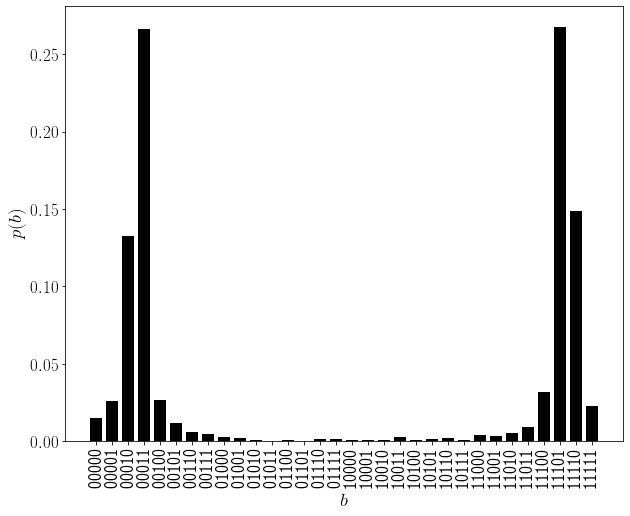

In [24]:
#labels = hist.keys()
probs=[]
print(hist.keys())
for key in labels:
    if np.any(np.array([*hist.keys()])==key):    
        probs.append(hist[key]/shots) 
    else:
        probs.append(0) 
    #print(hist[key])
#print(probs)
print(labels)
fig = plt.figure(figsize=figsize)
plt.bar(labels,probs,width=width,color=color)
plt.xticks(rotation='vertical')
plt.xlabel(r'$b$')
plt.ylabel(r'$p(b)$')
plt.savefig('result_n_'+str(n)+'_p_'+str(p)+'_nt_'+str(nt)+'_new.png')
plt.show()

0.4970703125
2.8487229862475445
2.3425376619667198
1.5305350900801717


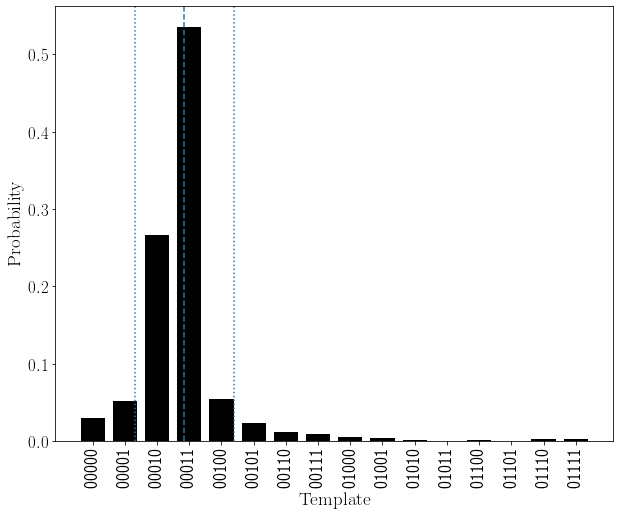

In [25]:
probs = np.array(probs)
probs_fold = probs[:int(len(probs)/2)]# + probs[int(len(probs)/2):][::-1]

print(np.sum(probs_fold))

probs_fold = probs_fold/np.sum(probs_fold)

mu = np.sum(probs_fold*np.arange(len(probs_fold)))
var = np.sum(probs_fold*np.arange(len(probs_fold))**2) - mu**2
sd = np.sqrt(var)

print(mu)
print(var)
print(sd)

fig = plt.figure(figsize=figsize)
plt.bar(labels[:int(len(probs)/2)],probs_fold,width=width,color=color)
plt.xticks(rotation='vertical')
plt.axvline(mu-sd,ls=':')
plt.axvline(mu,ls='--')
plt.axvline(mu+sd,ls=':')
plt.xlabel(r'\textrm{Template}')
plt.ylabel(r'\textrm{Probability}')
plt.show()
plt.close()

0.5029296875
13.014563106796118
2.6609529644641157
1.6312427668695164


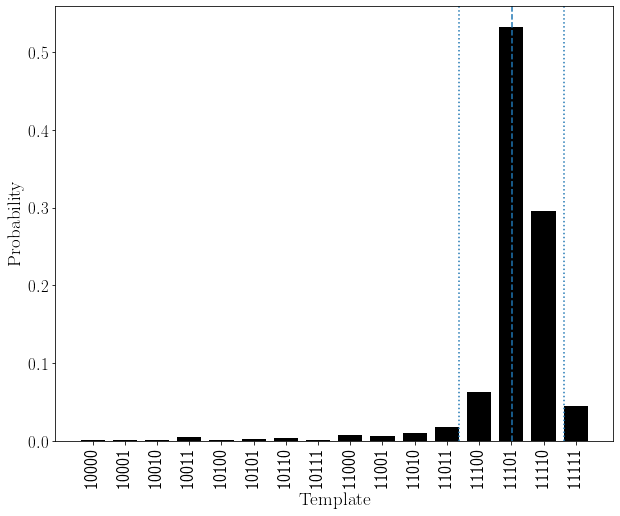

In [26]:
probs = np.array(probs)
probs_fold = probs[int(len(probs)/2):]

print(np.sum(probs_fold))

probs_fold = probs_fold/np.sum(probs_fold)

mu = np.sum(probs_fold*np.arange(len(probs_fold)))
var = np.sum(probs_fold*np.arange(len(probs_fold))**2) - mu**2
sd = np.sqrt(var)

print(mu)
print(var)
print(sd)

fig = plt.figure(figsize=figsize)
plt.bar(labels[int(len(probs)/2):],probs_fold,width=width,color=color)
plt.xticks(rotation='vertical')
plt.axvline(mu-sd,ls=':')
plt.axvline(mu,ls='--')
plt.axvline(mu+sd,ls=':')
plt.xlabel(r'\textrm{Template}')
plt.ylabel(r'\textrm{Probability}')
plt.show()
plt.close()

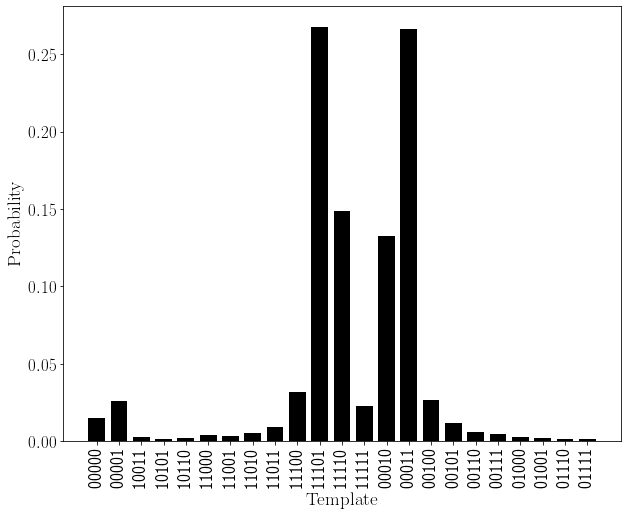

In [27]:
probs=[]
entry=[]
#print(hist.keys())
for key in hist.keys():
    if np.any(np.array(hist[key]/shots)>=0.001): 
        entry.append(key)
        probs.append(hist[key]/shots) 
fig = plt.figure(figsize=figsize)
plt.bar(entry,probs,width=width,color=color)
plt.xticks(rotation='vertical')
plt.xlabel(r'\textrm{Template}')
plt.ylabel(r'\textrm{Probability}')
plt.savefig('result_n_'+str(n)+'_p_'+str(p)+'_nt_'+str(nt)+'_clean.png')
plt.show()


In [28]:
measured_str = max(hist, key=hist.get)
measured_int = int(measured_str,2)
print("Register Output = %i" % measured_int)

Register Output = 29


Because there are two eigenvalues and we do not know which one is the measure value. We need to run them both and choose the more reasonable one.

In [29]:
kt=float(2**(p-2)/measured_int-1/2)
if kt<= 0:
    kt=float(1/(4*(1-measured_int/2**p))-1/2)
print (kt)
#kt1=float(1/(4*(1-measured_int/2**p))-1/2)
#print (kt1)

2.1666666666666665


Calculating how many matched templates there are

In [30]:
theta_t=np.pi/(2*(2*kt+1))
num_template=np.sin(theta_t)**2*2**n
print (num_template)

2.6964862031592753


In [31]:
# This is the calculated value of how many times Grover's Gate need to be applied
ktt=float(np.pi/4 *1/np.arcsin(np.sqrt((2**nt)/2**n))-0.5)
#ktt=np.floor(ktt)
print (ktt)

2.6082688394304085


## Step 4: Search for the template(s)

In [32]:
search_Circuit_2=QuantumCircuit(data,templates,result_answer)
search_Circuit_2.x(data[1])
search_Circuit_2.x(data[2])
search_Circuit_2.x(templates[n])
#Hadmard gate is applied to all qubits
search_Circuit_2.h(templates[0:a]) 
#search_Circuit_2.draw(output="mpl")

In [33]:
#search_circuit=QuantumCircuit(templates,data)
rep=0
if np.round(kt)==0.:
    rep=1
else:
    rep=np.round(kt).astype(int)
for i in range(rep):
    GroverGate(search_Circuit_2,n,nt)
    
#search_Circuit_2.draw(output='mpl')


    
    

In [34]:
#measurement
search_Circuit_2.measure(list(range(n,2*n)), result_answer[list(range(n))])


In [35]:
#experiment with the simulator
shots=2048
emulator = Aer.get_backend('qasm_simulator')
job = execute(search_Circuit_2, emulator, shots=shots )
answer = job.result().get_counts()


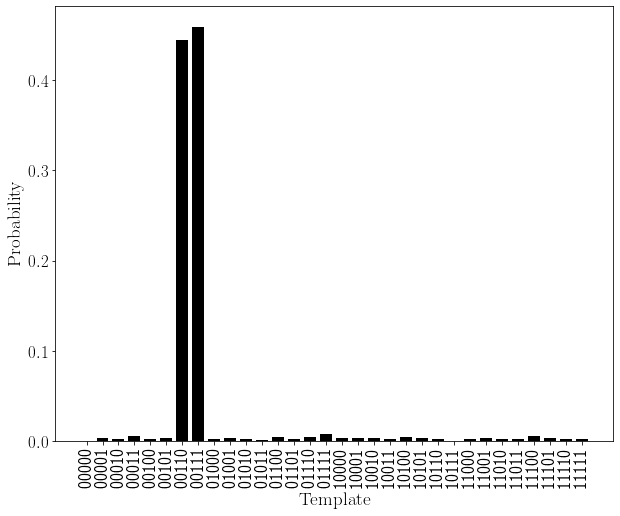

In [36]:
#labels = hist.keys()
labels=np.arange(2**n)
labels=binary_input(labels,n)
probs=[]
#print(hist.keys())
for key in labels:
    if np.any(np.array([*answer.keys()])==key):    
        probs.append(answer[key]/shots) 
    else:
        probs.append(0) 
#print(probs)
#print(labels)
fig = plt.figure(figsize=figsize)
plt.bar(labels,probs,width=width,color=color)
plt.xticks(rotation='vertical')
plt.xlabel(r'\textrm{Template}')
plt.ylabel(r'\textrm{Probability}')
plt.savefig('result_n_'+str(n)+'_p_'+str(p)+'_nt_'+str(nt)+'G'+'_new.png')
plt.show()

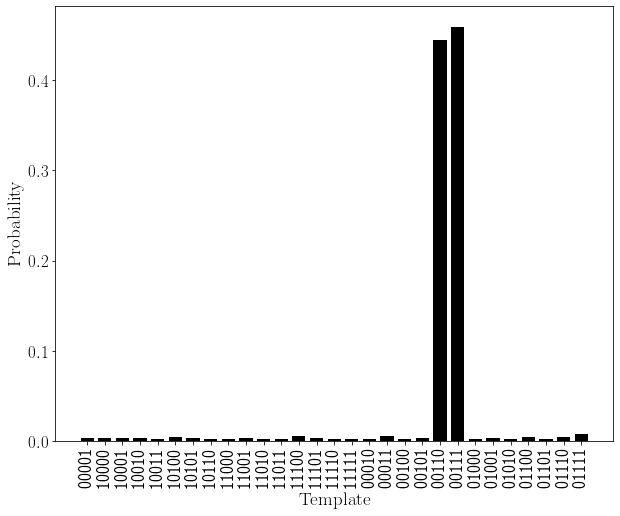

In [37]:
probs=[]
entry=[]
#print(hist.keys())
for key in answer.keys():
    if np.any(np.array(answer[key]/shots)>=0.001): 
        entry.append(key)
        probs.append(answer[key]/shots)
fig = plt.figure(figsize=figsize)
plt.bar(entry,probs,width=width,color=color)
plt.xticks(rotation='vertical')
plt.xlabel(r'\textrm{Template}')
plt.ylabel(r'\textrm{Probability}')
plt.savefig('result_n_'+str(n)+'_p_'+str(p)+'_nt_'+str(nt)+'Gr_clean.png')
plt.show()

In [38]:
plot_histogram(answer).savefig('result_n_'+str(n)+'_p_'+'_nt_'+str(nt)+str(p)+'_'+'og'+'Gr.png')

    